In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [0]:
import feature_string as feature_string
import feature_num as feature_num
import feature_categorica as feature_categorica
import common_machine_learning as common
import my_pipeline as my_pipe

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBRegressor

import time

import matplotlib.pyplot as plt

In [0]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Constates

In [0]:
TARGET = 'precio'

## Train

In [0]:
train = common.cargar_set_optimizado('/content/drive/My Drive/Colab Notebooks/sets_de_datos/train.csv')

In [0]:
X_test = common.cargar_set_optimizado('/content/drive/My Drive/Colab Notebooks/sets_de_datos/test.csv')

## Features

In [0]:
def limpiar(df):
    df['garages'] = df['garages'].fillna(0)
    df['metroscubiertos'] = df['metroscubiertos'].fillna(df.metroscubiertos.mean())
    df['antiguedad'] = df['antiguedad'].fillna(df.antiguedad.mean())
    df['banos'] = df['banos'].fillna(1)
    df['habitaciones'] = df['habitaciones'].fillna(df.habitaciones.mean())
    df['tipodepropiedad'] = df['tipodepropiedad'].fillna('Casa')
    df['metrostotales'] = df['metrostotales'].fillna(df['metrostotales'].mean())
    df['metroscubiertos'] = df['metroscubiertos'].fillna(df['metroscubiertos'].mean())
    df['ciudad'] = df['ciudad'].fillna("")

def nuevas_features(df, precios_tipo,precio_m2,promedios,default_m2):
    df['ratio_cubierto'] = df.apply(lambda x: x['metroscubiertos']/x['metrostotales'] if x['metrostotales'] else 1, axis = 1)
    df['tipodepropiedad_precio_mean'] = df['tipodepropiedad'].apply(lambda x: precios_tipo.loc[x]['precio_por_tipo'])
    df['precio_x_m2'] = df.apply(lambda x: precio_x_m2.get(x['ciudad'],default_m2), axis = 1)
    df['mean_hab'] = df.apply(lambda x: promedios['mean_hab'].get(x['ciudad'],default_m2), axis = 1)
    df['mean_ban'] = df.apply(lambda x: promedios['mean_ban'].get(x['ciudad'],default_m2), axis = 1)
    df['mean_gar'] = df.apply(lambda x: promedios['mean_gar'].get(x['ciudad'],default_m2), axis = 1)
    df['cantidad_extras'] = df['gimnasio'].astype(int) + df['usosmultiples'].astype(int)\
                            + df['piscina'].astype(int) + df['escuelascercanas'].astype(int)\
                            + df['centroscomercialescercanos'].astype(int)

In [0]:
limpiar(train)

In [0]:
limpiar(X_test)

In [0]:
train_precios_por_tipo = train.groupby('tipodepropiedad').agg({'precio':'mean'}).rename(columns={'precio':'precio_por_tipo'})
train['precio_x_m2'] = train['precio']/train['metroscubiertos']
precio_x_m2 = train.groupby('ciudad').agg({'precio_x_m2':'mean'}).to_dict()['precio_x_m2']
default_m2 = train.groupby('ciudad').agg({'precio_x_m2':'mean'})['precio_x_m2'].mean()
promedios = train.set_index('ciudad')\
            .join(train.groupby('ciudad')\
                  .agg({'habitaciones':'mean', 'garages':'mean', 'banos':'mean'})\
                      .rename(columns={'habitaciones':'mean_hab', 'banos':'mean_ban', 'garages':'mean_gar'}))\
                        [['mean_hab','mean_gar','mean_ban']].to_dict()

In [0]:
nuevas_features(train, train_precios_por_tipo, precio_x_m2, promedios, default_m2)

In [0]:
nuevas_features(X_test, train_precios_por_tipo, precio_x_m2, promedios, default_m2)

In [0]:
train = feature_num.completar_lat_lng_con_provincias_y_ciudades(train)
train = feature_num.completar_lat_lng_con_idzona_mean(train)
feature_num.completar_lat_lng_con_promedio_Mexico(train)

In [0]:
X_test = feature_num.completar_lat_lng_con_provincias_y_ciudades(X_test)
X_test = feature_num.completar_lat_lng_con_idzona_mean(X_test)
feature_num.completar_lat_lng_con_promedio_Mexico(X_test)

In [0]:
feature_num.agregar_feature_fecha_numerica(train)

In [0]:
feature_num.agregar_feature_fecha_numerica(X_test)

In [0]:
train_categorias_descripciones = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_train_categorias_descripciones.csv')

In [0]:
test_categorias_descripciones = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_test_categorias_descripciones.csv')

In [0]:
nuevo_train = train.copy()

In [0]:
nuevo_X_test = X_test.copy()

In [0]:
train_categorias_descripciones.rename(columns = {'categoria' : 'categoria_descripcion'}, inplace = True)

In [0]:
test_categorias_descripciones.rename(columns = {'categoria' : 'categoria_descripcion'}, inplace = True)

In [163]:
test_categorias_descripciones

,id,categoria_descripcion
0,4941,1
1,51775,1
2,115253,1
3,299321,0
4,173570,0
...,...,...
59995,75094,1
59996,171847,0
59997,138313,0
59998,271268,0


In [0]:
nuevo_train = nuevo_train.merge(train_categorias_descripciones, on = 'id')

In [0]:
nuevo_X_test = nuevo_X_test.merge(test_categorias_descripciones, on = 'id')

In [0]:
FEATURES = [
            'tipodepropiedad_precio_mean', 
            'lat', 
            'lng', 
            'garages', 
            'habitaciones', 
            'antiguedad', 
            'metroscubiertos', 
            'banos', 
            'ratio_cubierto', 
            'mean_hab', 
            'mean_ban', 
            'mean_gar', 
            'precio_x_m2',
            'cantidad_extras',
            'fecha_numerica', 
            'categoria_descripcion',
            ]

In [0]:
train = nuevo_train.copy()

In [0]:
X_test = nuevo_X_test.copy()

In [0]:
train.set_index('id', inplace = True)

In [0]:
X_test.set_index('id', inplace = True)

In [173]:
X_test

,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,ratio_cubierto,tipodepropiedad_precio_mean,precio_x_m2,mean_hab,mean_ban,mean_gar,cantidad_extras,fecha_numerica,categoria_descripcion
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29.0,3.0,0.0,4.0,300.0,inf,NaN,19.408668,-99.246767,2013-07-20,False,False,False,False,False,0.000000,2398109.50,31591.029297,2.474609,1.866211,1.302734,0,20130720,1
51775,departamentos en venta en montebello,<p>departamento una recamara:\n</p><p>departam...,Apartamento,NaN,Mérida,Yucatán,inf,1.0,1.0,1.0,67.0,67.0,113851.0,21.032480,-89.592424,2015-10-24,False,False,False,False,False,1.000000,2763768.75,9641.221680,2.929688,2.425781,1.357422,0,20151024,1
115253,departamento nuevo delegación coyoacán de 87 m...,"departamento nuevo de 87.06 m2, 1 cajón de est...",Apartamento,"Pueblo de los Reyes, Coyoacán, Mexico D.F.",Coyoacán,Distrito Federal,0.0,2.0,1.0,2.0,87.0,100.0,23620.0,19.332829,-99.152913,2015-05-30,False,False,False,False,True,0.870000,2763768.75,19838.160156,3.033203,1.979492,1.336914,1,20150530,1
299321,departamento en venta en acapulco,<p> raíces dv001 precioso departamento tipo k...,Apartamento,NaN,Acapulco de Juárez,Guerrero,2.0,2.0,2.0,2.0,86.0,86.0,129347.0,16.860487,-99.878383,2015-04-02,False,False,False,False,False,1.000000,2763768.75,15299.990234,2.820312,2.199219,1.224609,0,20150402,0
173570,bonita casa sola equipada de dos niveles en lo...,"<p>casa sola, bonita de dos rec&aacute;maras u...",Casa,CEDROS,Tultitlán,Edo. de México,10.0,2.0,1.0,1.0,80.0,76.0,57125.0,19.640482,-99.127273,2013-08-15,False,False,False,True,True,1.052632,2398109.50,8756.561523,2.791016,1.339844,1.074219,2,20130815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75094,oportunidad!! se vende amplia casa en col. moc...,oportunidad!! ideal para oficina o casa habita...,Casa,Oriente 172 # 265,Venustiano Carranza,Distrito Federal,20.0,4.0,3.0,3.0,291.0,inf,275741.0,19.434821,-99.092517,2015-09-19,False,False,False,True,True,0.000000,2398109.50,15195.627930,2.810547,1.498047,0.849121,2,20150919,1
171847,colinas de ecatepec,"casa, sala comedor, patio de servicio, buenas ...",Casa,colinas,Ecatepec de Morelos,Edo. de México,10.0,3.0,1.0,2.0,71.0,87.0,57474.0,23.062283,-109.699951,2016-10-19,False,False,False,True,True,0.816092,2398109.50,8651.694336,2.955078,1.502930,1.185547,2,20161019,0
138313,estrene hermosa casa en sierra morena,hermosa casa lista para habitarse ubicada en f...,Casa,s/calle,Guadalupe,Nuevo León,5.0,3.0,2.0,2.0,102.0,inf,72224.0,23.062283,-109.699951,2014-12-02,False,False,False,True,True,0.000000,2398109.50,8173.222168,2.982422,1.865234,1.074219,2,20141202,0


## X & y

In [0]:
X = train[FEATURES].copy()
y = train[TARGET].copy()
X_test = X_test[FEATURES].copy()

In [0]:
model = XGBRegressor(
          objective = 'reg:squarederror', 
          gamma = 1.744100671242199,
          reg_lambda = 1.145385491145779,
          learning_rate = 0.02864154016413557,
          max_depth = 9,
          min_child_weight = 3,
          n_estimators  = 890
        )               

In [184]:
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1.744100671242199,
             importance_type='gain', learning_rate=0.02864154016413557,
             max_delta_step=0, max_depth=9, min_child_weight=3, missing=None,
             n_estimators=890, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1.145385491145779, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'Feature Importance Score')

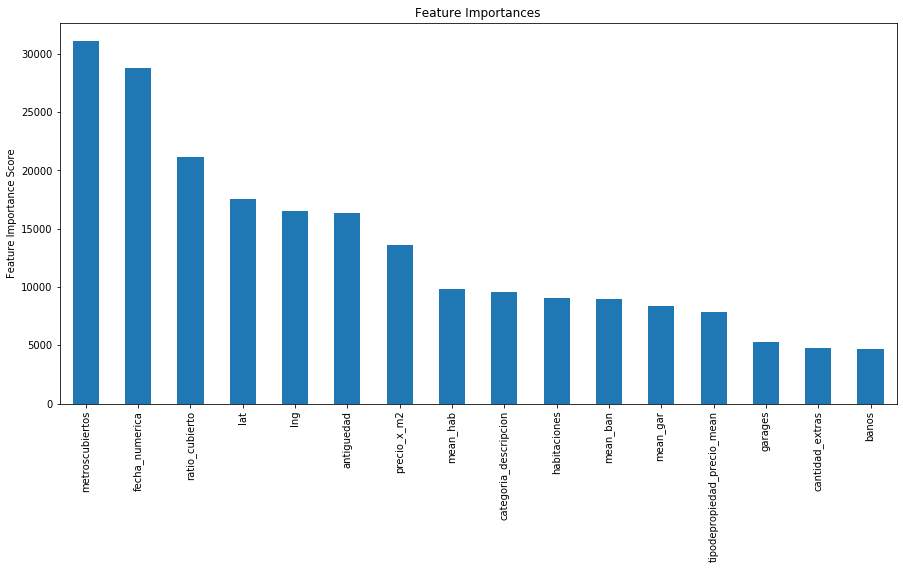

In [186]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(15, 7))
plt.ylabel('Feature Importance Score')

In [0]:
res = pd.DataFrame(y_pred, index=X_test.index, columns=['target'])
res.to_csv('/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_submit_xgboost_clasificador_descrip_6.csv', header=True)

In [189]:
res

,target
id,
4941,1.775013e+06
51775,1.356050e+06
115253,1.722833e+06
299321,8.181839e+05
173570,5.357357e+05
...,...
75094,1.122703e+06
171847,7.036179e+05
138313,8.730451e+05
